
## Split feasibility problem: Using LPs as subproblems

Hangzhou, Jan 28, 2023<br>
Written by Vu Thi Huong (vthuong@math.ac.vn) \
Institute of Mathematics, Vietnam Academy of Science and Technology \
The author would like to thank Tran Thu Le for providing [codes](https://github.com/Tran-Thu-Le/pyopt/blob/master/gradient_methods/conditional_gradient.ipynb?fbclid=IwAR39Xr9qG9EjgsOlVXut2UAaCwj63YZvQ6t-2N8TYU9A19EjLp5NZBnf_YE) to compute projection onto polyhedrons.

**Abstract.** In this note, we examine how linear programs (LPs) can be used as subproblems in finding solutions to a split feasibility problem (SFP). First, SFP is reformulated as a nonlinear convex optimization problem with smooth objective. Then, a gradient projection method is applied. The method requires computing projections onto convex sets in each steps. We show that if the sets are bounded polyhedrons, then LPs can be used to find the projections and thus the gradient projection method can be implemented easily.

### Split feasibility problem 
Let $C \subset \mathbb R^n$  and $Q \subset \mathbb R^m$ be nonempty, closed, and convex sets. Let $A \in \mathbb R^{m\times n}$ be a matrix. The *split feasibility problem* (SFP) is to find an $x \in C$ such that $Ax \in Q$. When $m = n$ and $A$ is the identity matrix, SFP becomes the *common point problem*, finding $x \in C \cap Q$.

Let $X^*:=\{x \in C \mid Ax \in Q\}$ be the solution set of SFP. Observe that $x^* \in X^*$ if and only if $x^*$ is an optimal solution of the following optimization problem:
\begin{equation}
\mbox{minimize} \quad f(x):=\dfrac{1}{2} \| Ax - P_Q(Ax)\|^2 \quad \mbox{subject to} \quad x \in C \tag{P}
\end{equation}

**Facts about (P):**
- This is a nonlinear convex minimization problem, i.e., nonlinear convex objective convex constraint;
- $f : \mathbb R^n \to \mathbb R$ continuously differentiable on $\mathbb R^n$;
- $\nabla f(x) = A^*(Ax - P_Q(Ax)), \quad \forall x \in \mathbb R^n$;
- $\|\nabla f(x) - \nabla f(y)\|\leq \|A\|^2 \|x -y \|, \quad \forall x , y \in \mathbb R^n$.

The last property means that the gradient of $f$ is globally Lipschitz continuous with Lipschitz constant $L:= \|A\|^2$. This allows us to solve (P) by the *gradient projection algorithm* (GPA) as follows.

\begin{equation}
x_0 \in C, \quad x_{n+1} = P_C(x_n - \gamma_n \nabla f(x_n)), \quad \forall n\geq 0. \tag{GPA}
\end{equation}

**Fact about GPA:** \
If $\gamma_n := \gamma \in (0, 2/L)$ for all $n \geq 0$, then the sequence $(x_n)$ produced by GPA converges to an optimal solution of (P); see [Polyak87, Theorem 1, p. 207].

==> To implement GPA, we need to compute the projections onto convex sets $P_C(\cdot), P_Q(\cdot)$ in each steps. In practice, this can be done if the sets $C, Q$ are of simple forms. In this note, we consider the case $m = n = 2$, $A$ is the identity matrix, and $C, Q$ are bounded sets given by linear inequalities

\begin{equation}\tag{1}
C:= \{x \in \mathbb R^2 : A_1x \leq b_1\}, A_1 \in \mathbb R^{d_1 \times 2}, b_1 \in \mathbb R^{2},\\
Q:= \{x \in \mathbb R^2 : A_2y \leq b_2\}, A_2 \in \mathbb R^{d_2 \times 2}, b_2 \in \mathbb R^{2}.
\end{equation}

### Projection onto convex set C
For any $u \in \mathbb R^2$, there is a unique point in $C$ denoted by $P_C(u)$ such that $\|P_C(u)-u\| \leq \|x-u\|$ for all $x \in C$. Thus, one has $$P_C(u)= \mbox{argmin} \{g(x) := \dfrac{1}{2} \|x - u\|^2 \mid x \in C\}.$$

This is a convex minimization problem with smooth objective (with $\nabla g(x) = x - u, \forall x \in \mathbb R^2$) and linear constraints (by the assumption on $C$). Thus, the *conditional gradient method* (also called [*Frank–Wolfe method*](https://en.wikipedia.org/wiki/Frank%E2%80%93Wolfe_algorithm)) can be applied as follows:

\begin{equation}\label{proj}
x_0 \in C, \quad x_{n+1} = x_n + \alpha_n (s_n - x_n)\quad \mbox{with} \quad \alpha_n = \dfrac{2}{n+2} \quad \mbox{and} \quad s_n = \mbox{argmin}\{\langle \nabla g(x_n), x \rangle \mid x \in C\},  \quad \forall n\geq 0. \tag{proj}
\end{equation}

==> Since $C$ is given by linear inequalities as assumed, each $s_n$ is computed via solving the linear program $\min\{\langle \nabla g(x_n), x \rangle \mid x \in C\}$. This will be done by function [linprog](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) in library scipy.optimize of Python.

Let us implement the algorithm \ref{proj}.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [99]:
def proj(u, A1, b1, x_init): 
    # u is the point to project
    # A1 and b1 are the matrix and vector defining the polyhedron C
    # x_init in C
    x = x_init
    x_list = [x_init]
    s_list = []
    for i in range(1, 30):
        grad = x-u
        s = linprog(grad, A_ub=A1, b_ub=b1).x
        alpha = 2/(i+2)
        x = x + alpha*(s-x)
        x_list += [x]
        s_list += [s]
    return x, x_list, s_list

In [100]:
u = np.array([1.5, 2])
A1 = np.array([[1, 1], [1, 0], [-1, 0], [0, -1]])
b1 = np.array([2, 1, 0, 0])
x_init = np.array([1, 0])

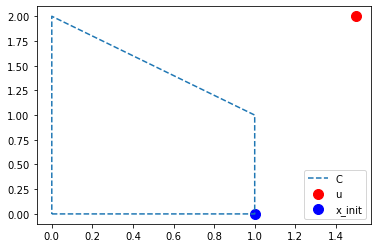

In [101]:
Cnodes = [(0, 0), (1, 0), (1, 1), (0, 2), (0, 0)]
Cnodes = np.array(Cnodes).T 
plt.plot(Cnodes[0], Cnodes[1], ls="--", label = "C")
plt.scatter(u[0], u[1], c="red", s=100, label="u")
plt.scatter(x_init[0], x_init[1], c="blue", s=100, label="x_init")
#plt.xlim(-0.2, 3.0)
#plt.title("Projection onto convex set C")
plt.legend()
plt.show()

In [102]:
# we now run proj
proj_u_C, x_list, s_list = proj(u, A1, b1, x_init)
print("optimal solution is", x_opt)

optimal solution is [1.03225806 0.51612903]


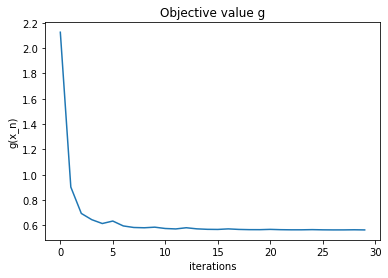

In [103]:
# plot objective values g(x_n)
g_list = [0.5*np.linalg.norm(x-u)**2 for x in x_list]
plt.plot(g_list)
plt.title("Objective value g")
plt.xlabel("iterations")
plt.ylabel("g(x_n)")
plt.show()


From the figure we see that proj is not a descent method, i.e., it does not make the objective function $g$ decreasing after every iteration.  

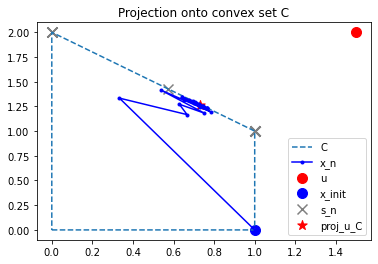

In [104]:
# visualization of iterations
#nodes = [(0, 0), (1, 0), (1, 1), (0, 2), (0, 0)]
#nodes = np.array(nodes).T 
x_list = np.array(x_list).T
s_list = np.array(s_list).T

plt.plot(Cnodes[0], Cnodes[1], ls="--", label = "C")
plt.scatter(u[0], u[1], c="red", s=100, label="u")
plt.scatter(x_init[0], x_init[1], c="blue", s=100, label="x_init")
plt.scatter(s_list[0], s_list[1], c="gray", s=100, marker="x", label="s_n")
plt.plot(x_list[0, [i for i in range (0, 28)]], x_list[1, [j for j in range (0, 28)]], c="blue", marker=".", label="x_n")
plt.scatter(proj_u_C[0], proj_u_C[1], c="red", s=100, marker="*", label="proj_u_C")
#plt.xlim(-0.2, 3.0)
plt.title("Projection onto convex set C")
plt.legend()
plt.show()

From the figure, we see that the sequence $(x_n)$ converges to $P_C(u)$.

We are now ready to implement the gradient projection algorithm GPA to solve a special case of the split feasibily problem.

### Common point problem 
Find $x \in C \cap Q$ with 
\begin{equation}
C:= \{x \in \mathbb R^2 : A_1x \leq b_1\}, A_1 \in \mathbb R^{d_1 \times 2}, b_1 \in \mathbb R^{2},\\
Q:= \{x \in \mathbb R^2 : A_2y \leq b_2\}, A_2 \in \mathbb R^{d_2 \times 2}, b_2 \in \mathbb R^{2}
\end{equation}
or equivalently, solve the problem
\begin{equation}
\mbox{minimize} \quad f(x):=\dfrac{1}{2} \| x - P_Q(x)\|^2 \quad \mbox{subject to} \quad x \in C. 
\end{equation}

One has $\nabla f(x) = x - P_Q(x)$ for all $x \in \mathbb R^2$ and $\nabla f$ is globally Lipschitz with constant $L:=1$. Gradient projection algorithm with constant stepsize:

\begin{equation}
x_0 \in C, \quad \gamma \in (0, 2), \quad \nabla f(x_n) = x_n - P_Q(x_n), \quad x_{n+1} = P_C(x_n - \gamma \nabla f(x_n)), \quad \forall n\geq 0 \tag{commonPoint}. 
\end{equation}

We define the function named *commonPoint* depending on data of $C$ and $Q$ (see again formula (1) above): $A1$ and $b1$ are the metrix and vector defining the set $C$. Similarly, $A2$ and $b2$ are the metrix and vector defining the set $Q$.  We also need initial points $x_{init1} \in C$ and $x_{init2} \in Q$ so that we can compute the projection $P_C(\cdot), P_Q(\cdot)$ by function proj in the last section.

In [105]:
def commonPoint(A1, b1, x_init1, A2, b2, x_init2):
    x = x_init1
    gamma = 1
    x_list = [x_init1]
    for j in range(1, 50):
        gradf = x - proj(x, A2, b2, x_init2)[0]
        y = x - gamma*gradf
        x = proj(y, A1, b1, x_init1)[0]
        x_list += [x]
    return x, x_list

Let us try with the following data:

In [106]:
A1 = np.array([[1, 1], [-1, 0], [0, -1]])
b1 = np.array([2, 0, 0])
x_init1 = np.array([0, 2])

A2 = np.array([[-1, 2], [-1, 0], [1, 0], [0, -1]])
b2= np.array([0, 0, 2, 0])
x_init2 = np.array([2, 1])

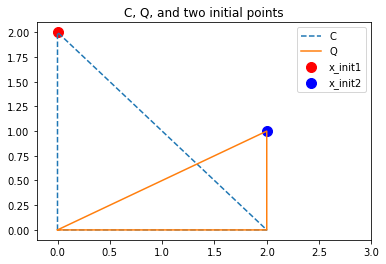

In [107]:
#Visualizing the data
Cnodes = [(0, 0), (0, 2), (2, 0), (0, 0)]
Cnodes = np.array(Cnodes).T 
Qnodes = [(0, 0), (2, 0), (2, 1), (0, 0)]
Qnodes = np.array(Qnodes).T
plt.plot(Cnodes[0], Cnodes[1], ls="--", label = "C")
plt.plot(Qnodes[0], Qnodes[1], ls="-", label = "Q")
plt.scatter(x_init1[0], x_init1[1], c="red", s=100, label="x_init1")
plt.scatter(x_init2[0], x_init2[1], c="blue", s=100, label="x_init2")
plt.xlim(-0.2, 3.0)
plt.title("C, Q, and two initial points")
plt.legend()
plt.show()

In [108]:
#solve the common point problem
x_opt, x_list = commonPoint(A1, b1, x_init1, A2, b2, x_init2)
f_opt = [0.5*np.linalg.norm(x - proj(x, A2, b2, x_init2)[0])**2]

print("Optimal solution is x_opt = ", x_opt)
print("Optimal value is f_opt = ", f_opt)

Optimal solution is x_opt =  [1.03225806 0.51612903]
Optimal value is f_opt =  [0.0007993074920092675]


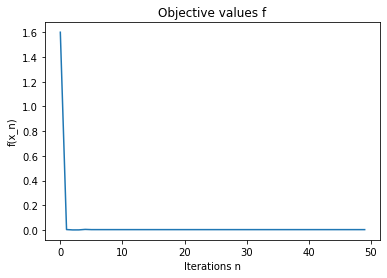

In [109]:
# plot objective values
f_list = [0.5*np.linalg.norm(x-proj(x, A2, b2, x_init2)[0])**2 for x in x_list]
plt.plot(f_list)
plt.title("Objective values f")
plt.xlabel("Iterations n")
plt.ylabel("f(x_n)")
plt.show()

From the figure, we see that  the objective function $f$ reach optimal value $0$ after 1 iteration and $f(x_n)$ sticks to the optimal value for all $n\geq 2$. This seems good so far.

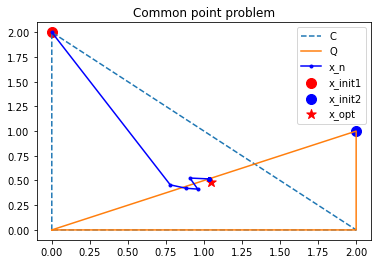

In [110]:
# visualization of iterations
Cnodes = [(0, 0), (0, 2), (2, 0), (0, 0)]
Cnodes = np.array(Cnodes).T 
Qnodes = [(0, 0), (2, 0), (2, 1), (0, 0)]
Qnodes = np.array(Qnodes).T
x_list = np.array(x_list).T
plt.plot(Cnodes[0], Cnodes[1], ls="--", label = "C")
plt.plot(Qnodes[0], Qnodes[1], ls="-", label = "Q")
plt.scatter(x_init1[0], x_init1[1], c="red", s=100, label="x_init1")
plt.scatter(x_init2[0], x_init2[1], c="blue", s=100, label="x_init2")
plt.scatter(x[0], x[1], c="red", s=100, marker="*", label="x_opt")
plt.plot(x_list[0, [i for i in range (0, 48)]], x_list[1, [j for j in range (0, 48)]], c="blue", marker=".", label="x_n")
#plt.xlim(-0.2, 3.0)
plt.title("Common point problem")
plt.legend()
plt.show()
#i for i in range (0, 99)
#j for j in range (0, 99)

From the figure, we see that the sequence $(x_n)$ converges to x_opt which is a commont point of $C, Q$. I have tried with the bigger number of iterations like 100, 300, and obtain same x_opt. **But why does the algorithm not keep staying at the first time meeting the set $C \cap Q$, in this case is at $x_2$?**